In [52]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import phate, magic, meld
import pandas as pd
import dbio, os
import scprep
import graphtools as gt

font = {'size'   : 18}
mpl.rc('font', **font)

In [54]:
base_path = '/data/lab/DataSets/SBRT/20170601-RD3475-Run_1/'

def load_fcs(path):
    meta, x = dbio.fcsextract(path)
    
    gene_names = {}
    for i in range(1,x.shape[1]+1):
        key = '$P{}S'.format(i)
        if key in meta:
            if '_' in meta[key]:
                gene_names[i] = meta[key].split('_')[1]
            else:
                gene_names[i] = meta[key]
        else:
            key = '$P{}N'.format(i)
            gene_names[i] = meta[key]
    
    gene_names = np.array([*gene_names.values()])
    
    markers = np.array(['Event_length', 'CD45', 'CD196', 'T-bet', 'CD127',
       'CD69', 'CD4', 'CD8a', 'CD7', 'CD200R', 'CD25', 'CD38',
       'Beads-CD278', 'TNFa', 'Baeds-Tim-3', 'CD185', 'CD36', 'CD95',
       'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3', 'CD45RO',
       'Beads-IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3', 'CD226',
       'CD274', 'TIGIT', 'TCF7', 'Beads-PD-1', 'IL-10', 'DNA1', 'DNA2',
       'Cispt', 'CD11b'], dtype='<U12')
    
    assert np.all([m in gene_names for m in markers])
    
    data = pd.DataFrame(x, columns = gene_names)
    marker_data = scprep.utils.select_cols(data, markers)
    return marker_data
    #return data


### Importing data

In [55]:
sample_info = pd.read_csv('../files/sample_info.csv', index_col=0)

# Generate Index
sample_names = []
for ix, s_info in sample_info.iterrows():
    sample_name = '_'.join([s_info['sample_id'], s_info['response'], s_info['pre_post_sbrt']])
    sample_names.append(sample_name)

sample_info.index = pd.Index(sample_names)

#### Select Pre and Post-1 from Run 1

In [56]:
sample_mask = np.isin(sample_info['time_RES'], [-1, 1]) & sample_info['run'] == 1

#### Load data

In [57]:
all_data = []
for fn in sample_info.loc[sample_mask]['filename']:
    all_data.append(load_fcs(os.path.join(base_path, fn)))

In [58]:
data, batches = scprep.utils.combine_batches(all_data, sample_info.loc[sample_mask].index)

metadata = sample_info.loc[batches]

In [59]:
curr_batch_order = np.array(['L-18_Excellent_Pre',
'L-18_Excellent_Post-1',
'L-20_Excellent_Pre',
'L-20_Excellent_Post-1',
'L-29_Fair_Pre',
'L-29_Fair_Post-1',
'L-41_Fair_Pre',
'L-41_Fair_Post-1',
'L-2_Poor_Pre',
'L-2_Poor_Post-1',
'L-59_Poor_Pre',
'L-59_Poor_Post-1'])

In [60]:
groups, counts = np.unique(batches, return_counts=True)

In [61]:
batch_cmap = {g:sns.husl_palette(len(groups))[np.where(curr_batch_order == g)[0][0]] for g in groups}


### QC & Processing

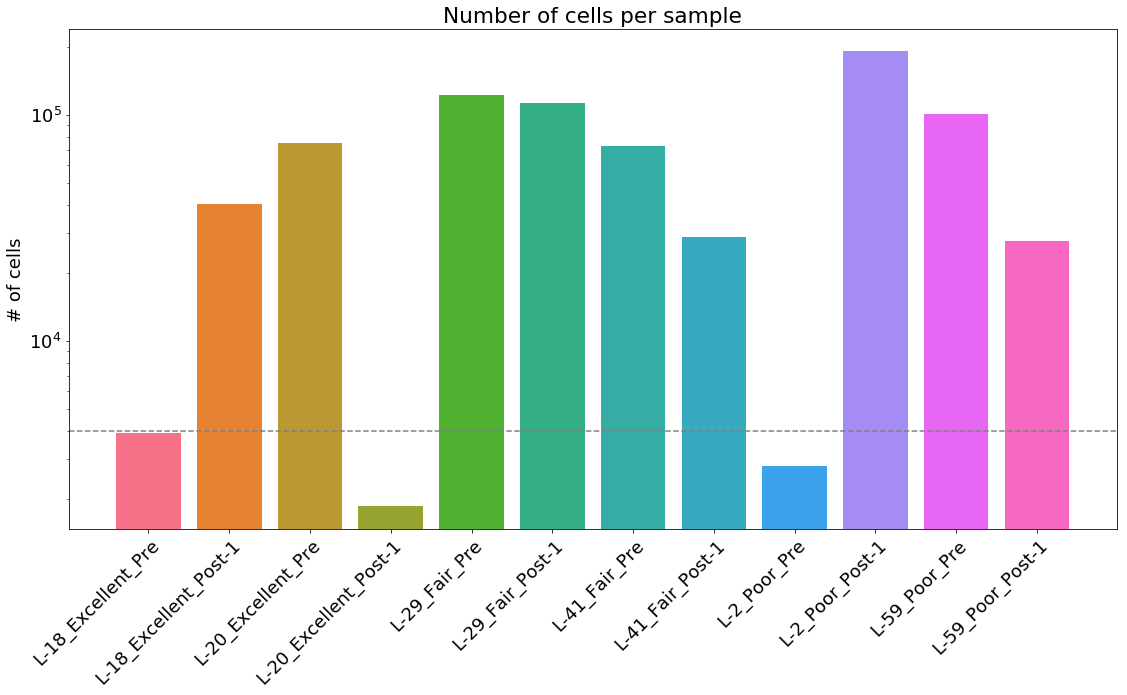

In [62]:
fig, ax = plt.subplots(1, figsize=(16,10))
i = -1
for group, count in zip(groups, counts):
    i = np.where(curr_batch_order == group)[0][0]
    ax.bar(i, count, color=batch_cmap[group])
ax.set_xticks(np.arange(len(groups)))   
ax.set_xticklabels(curr_batch_order, rotation=45, ha='right')
ax.set_ylabel('# of cells')
ax.set_yscale('log')

ax.axhline(4000, linestyle='--', color='grey')

dbio.shift_ticklabels(fig, ax, dx=0.2)

ax.set_title('Number of cells per sample')

fig.tight_layout()
fig.savefig('../figs/pre_at_post/cells_per_sample.png', dpi=300)

In [63]:
# Number of cells in each sample
print(*zip(groups, counts), sep='\n')

('L-18_Excellent_Post-1', 40144)
('L-18_Excellent_Pre', 3925)
('L-20_Excellent_Post-1', 1853)
('L-20_Excellent_Pre', 75025)
('L-29_Fair_Post-1', 112879)
('L-29_Fair_Pre', 122565)
('L-2_Poor_Post-1', 190475)
('L-2_Poor_Pre', 2795)
('L-41_Fair_Post-1', 28814)
('L-41_Fair_Pre', 72653)
('L-59_Poor_Post-1', 27728)
('L-59_Poor_Pre', 101032)


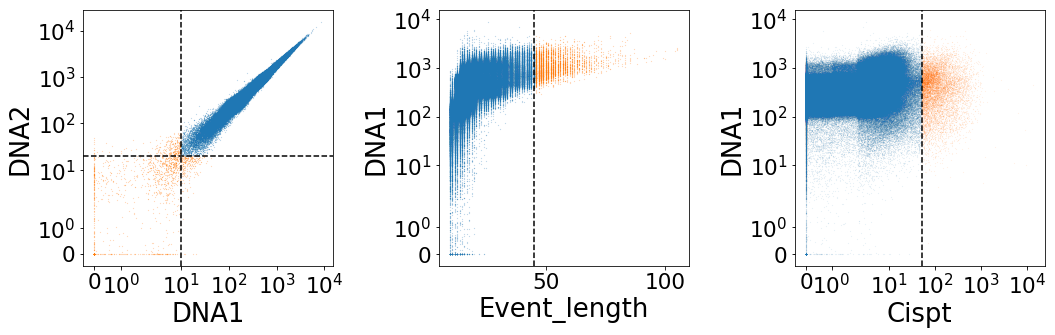

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# DNA1 vs DNA2
ax = axes[0]
ax.set_xscale('symlog')
ax.set_yscale('symlog')

dna1_thresh = 10
dna2_thresh = 20

m1 = data['DNA1'] < dna1_thresh
m2 = data['DNA2'] < dna2_thresh
dna_m = m1 | m2
ax.axvline(dna1_thresh, linestyle='--', c='k')
ax.axhline(dna2_thresh, linestyle='--', c='k')
scprep.plot.scatter(data['DNA1'].loc[~dna_m], data['DNA2'].loc[~dna_m], 
                    ax=ax, s=0.01)

scprep.plot.scatter(data['DNA1'].loc[dna_m], data['DNA2'].loc[dna_m], ax=ax,
                    xlabel='DNA1', ylabel='DNA2', s=0.01)

# event_length vs DNA1
ax = axes[1]
x = 'Event_length'
y = 'DNA1'
ax.set_yscale('symlog')

# Threshold
event_thresh = 45
event_m = data[x] > event_thresh

# Plot
scprep.plot.scatter(data[x][~event_m], data[y][~event_m], ax=ax,
                   xlabel=x, ylabel=y, s=0.01)
scprep.plot.scatter(data[x].loc[event_m], data[y].loc[event_m], ax=ax, s=0.01)

ax.axvline(event_thresh, linestyle='--', c='k')

## Cispt vs DNA1
ax = axes[2]
x = 'Cispt'
y = 'DNA1'

ax.set_xscale('symlog')
ax.set_yscale('symlog')

# Threshold
cispt_thresh = 50
cispt_m = data[x] > cispt_thresh

# Plot
scprep.plot.scatter(data[x].loc[~cispt_m], data[y].loc[~cispt_m], ax=ax,
                  s=0.001)
scprep.plot.scatter(data[x].loc[cispt_m], data[y].loc[cispt_m], ax=ax,
                    xlabel=x, ylabel=y, s=0.001)
ax.axvline(cispt_thresh, linestyle='--', c='k')


fig.tight_layout()
fig.savefig('../figs/pre_at_post/all.filtering.png', dpi=300)

#### Filtering data

In [65]:
full_mask = cispt_m | dna_m | event_m

In [66]:
data_fil = data[~full_mask]
batches_fil = batches[~full_mask]

#### Keeping only relevant markers

In [67]:
markers = np.array(['CD45', 'CD196', 'T-bet', 'CD127',
       'CD69', 'CD4', 'CD8a', 'CD7', 'CD200R', 'CD25', 'CD38',
       'Beads-CD278', 'TNFa', 'CD185', 'CD36', 'CD95',
       'CD137', 'CD197', 'CD28', 'CD152', 'FoxP3', 'CXCR3', 'CD45RO',
       'Beads-IFNg', 'LAG-3', 'GzmB', 'Ki-67', 'Eomes', 'CD3', 'CD226',
       'CD274', 'TIGIT', 'TCF7', 'Beads-PD-1', 'IL-10', 'CD11b'], dtype='<U12')

In [68]:
marker_data = scprep.utils.select_cols(data_fil, markers)
print(marker_data.shape)
marker_data.head()

(764685, 36)


,CD45,CD196,T-bet,CD127,CD69,CD4,CD8a,CD7,CD200R,CD25,...,Ki-67,Eomes,CD3,CD226,CD274,TIGIT,TCF7,Beads-PD-1,IL-10,CD11b
0,340.005768,0.983165,9.287354,3.554659,1.147225,0.000000,335.564178,56.270885,1.183995,0.000000,...,6.018753,2.461942,33.877903,0.000000,0.000000,0.00000,4.816284,0.376825,1.545538,7.746138
1,160.587997,1.389618,0.202423,0.000000,8.130103,0.000000,0.000000,0.886329,0.000000,0.000000,...,0.690990,0.000000,0.000000,0.000000,0.712116,0.00000,0.821965,0.000000,0.000000,0.686727
2,25.655066,0.000000,0.000000,0.000000,0.000000,0.096433,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.545334,0.000000,0.000000,0.069644,0.00000,0.000000,0.000000,0.529302,43.126690
3,52.571316,2.525478,1.595829,1.195643,0.000000,7.724453,0.000000,0.000000,0.000000,1.790105,...,13.592545,4.397418,2.711127,0.000000,2.140911,0.00000,0.345581,0.000000,0.000000,34.604671
5,196.704529,22.875799,1.316943,4.390024,11.870975,39.665657,0.000000,1.992508,0.052038,0.000000,...,3.527546,1.518503,98.795441,6.484179,0.470307,0.51575,1.108884,1.327211,0.180620,0.479700


In [69]:
g, c = np.unique(batches, return_counts=True)
print(*zip(g,c), sep='\n')

('L-18_Excellent_Post-1', 40144)
('L-18_Excellent_Pre', 3925)
('L-20_Excellent_Post-1', 1853)
('L-20_Excellent_Pre', 75025)
('L-29_Fair_Post-1', 112879)
('L-29_Fair_Pre', 122565)
('L-2_Poor_Post-1', 190475)
('L-2_Poor_Pre', 2795)
('L-41_Fair_Post-1', 28814)
('L-41_Fair_Pre', 72653)
('L-59_Poor_Post-1', 27728)
('L-59_Poor_Pre', 101032)


#### Subsample data

In [70]:
data_sub = []
n_subsample = 4000
np.random.seed(42)
for b in np.unique(batches_fil):
    curr_data = scprep.utils.select_rows(marker_data, np.isin(batches_fil, b))
    if curr_data.shape[0] <= n_subsample:
        curr_subsamp = curr_data
        print(b, curr_data.shape)
    else:
        
        idx = np.random.choice(curr_data.index, n_subsample, replace=False)
        curr_subsamp = curr_data.loc[idx]
    data_sub.append(curr_subsamp)

L-18_Excellent_Pre (3442, 36)
L-20_Excellent_Post-1 (1732, 36)
L-2_Poor_Pre (2447, 36)


#### Combining subsampled batches and removing duplicates

In [71]:
data_sub, batches_sub = scprep.utils.combine_batches(data_sub, np.unique(np.unique(batches_fil)))

data_sub = data_sub.reset_index(drop=True)

batches_sub = pd.Series(batches_sub, index=data_sub.index)

data_ln = scprep.normalize.library_size_normalize(data_sub)

data_asin = scprep.transform.arcsinh(data_ln)

data_asin = data_asin.drop_duplicates()

batches_sub = batches_sub.loc[data_asin.index]

#### Generating metadata variable

In [72]:
metadata = sample_info.loc[batches_sub]

### PHATE embedding

In [108]:
G = gt.Graph(data_asin, knn=20, use_pygsp=True)

In [ ]:
phate_op = phate.PHATE(knn_dist='precomputed', n_jobs=6)
Y = phate_op.fit_transform(G.K)

Calculating PHATE...
  Using precomputed affinity matrix...
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 4.02 seconds.
  Calculating landmark operator...
    Calculating SVD...


In [75]:
phate_op = phate.PHATE(n_components=3, knn_dist='precomputed', n_jobs=12)
Y3D = phate_op.fit_transform(G.K)

Calculating PHATE...
  Using precomputed affinity matrix...
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 4.30 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 187.69 seconds.
    Calculating KMeans...
    Calculated KMeans in 36.33 seconds.
  Calculated landmark operator in 230.54 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.78 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.32 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 47.59 seconds.
Calculated PHATE in 283.60 seconds.


#### MAGIC

In [110]:
import magic

magic_op = magic.MAGIC(k=G.knn, n_pca = G.n_pca, a=G.decay)
data_magic = magic_op.fit_transform(data_asin, graph=G)

data_magic = pd.DataFrame(data_magic, columns = data_asin.columns)

Calculating MAGIC...
  Running MAGIC on 43620 cells and 36 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
    Automatically selected t = 10
  Calculated imputation in 15.80 seconds.
Calculated MAGIC in 15.82 seconds.


In [ ]:
np.savez('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.phate.npz',Y=Y, Y3=Y3D)
G.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.graph.pkl')
data_asin.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.data.pkl')
metadata.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.metadata.pkl')
data_magic.to_pickle('/home/dan/data/burkhardt/sbrt_trial/run1.pre_and_post.data_magic.pkl')